# 1. Packages

In [2]:
# Data clean
import pandas as pd 
import numpy as np
import json
from functools import reduce

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Model Train
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Analysis 
from pdpbox import pdp
from pdpbox import pdp, get_example, info_plots

# Model save and load
import joblib

# Other
import warnings
warnings.filterwarnings('ignore')


# 2. Data Loading
- Load .txt file and transfer to dataframe;
- Check number of rows and columns 
- Check datatype
- Statistic describe: mean, median, unique value, mode

In [3]:
file_path = '/Users/shouzhenghuang/fraud_dection/data/transactions.txt'

In [4]:
# Define data loading
def data_loading(path):
    # Open the file
    with open(file_path,'r') as file:
        data = file.read()
    #Split it to list, use strip to drop '' in the end
    data_json = data.strip().split('\n')
    #Convert to dictionary
    data_dictionary = [json.loads(record) for record in data_json]
    #Replace `''` as None 
    data_dictionary = [{key: value if value != '' else None for key, value in record.items()} for record in data_dictionary]
    #Convert to dataframe
    df = pd.DataFrame(data_dictionary)

    return df

df = data_loading(file_path)

# Set display options
pd.set_option('display.max_columns', None)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,None,0.0,None,None,None,False,None,None,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,None,0.0,None,None,None,True,None,None,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,None,0.0,None,None,None,False,None,None,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,None,0.0,None,None,None,False,None,None,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,None,0.0,None,None,None,True,None,None,False,False


In [10]:
df['merchantName'].unique()[:20]

array(['Uber', 'AMC #191138', 'Play Store', 'Tim Hortons #947751',
       'In-N-Out #422833', 'Krispy Kreme #685312', 'Shake Shack #968081',
       'Burger King #486122', 'Five Guys #510989',
       "Auntie Anne's #747964", 'GreenCook', 'Washington Repair',
       'Eazy Tire', 'Convenient Auto Services', 'Shell Auto Body',
       'Fast Auto Services', 'staples.com', 'Convenient Repair',
       'Shell Repair', 'Eazy Repair'], dtype=object)

In [6]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [5]:
# Datetime, Numerical, Categorical Features

datetime_columns = ['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']
df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)

numeric_columns = list(df.select_dtypes(include=['float', 'int']).columns)

category_columns = list(df.select_dtypes(include=['object','bool']).columns)

print(f'Datetime Columns   : {datetime_columns}')
print(f'Numerical Columns   : {numeric_columns}')
print(f'Categorical Columns : {category_columns}')


Datetime Columns   : ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
Numerical Columns   : ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
Categorical Columns : ['accountNumber', 'customerId', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud']


In [6]:
# Check transaction time period
df['transactionDateTime'].min(), df['transactionDateTime'].max()

(Timestamp('2016-01-01 00:01:02'), Timestamp('2016-12-30 23:59:45'))

In [7]:
### Statistic Describe
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
creditLimit,786363.0,10759.464459,11636.174890,250.00,5000.00,7500.00,15000.000,50000.00
availableMoney,786363.0,6250.725369,8880.783989,-1005.63,1077.42,3184.86,7500.000,50000.00
transactionAmount,786363.0,136.985791,147.725569,0.00,33.65,87.90,191.480,2011.54
currentBalance,786363.0,4508.739089,6457.442068,0.00,689.91,2451.76,5291.095,47498.81


In [8]:
# Category Columns Description
df[category_columns].describe().T

,count,unique,top,freq
accountNumber,786363,5000,380680241,32850
customerId,786363,5000,380680241,32850
merchantName,786363,2490,Uber,25613
acqCountry,781801,4,US,774709
merchantCountryCode,785639,4,US,778511
posEntryMode,782309,5,05,315035
posConditionCode,785954,3,01,628787
merchantCategoryCode,786363,19,online_retail,202156
cardCVV,786363,899,869,33749
enteredCVV,786363,976,869,33424


## <font color='blue'>Insight

### <font color='blue'>1) There are 29 columns with 786,363 records
### <font color='blue'>2) Transaction happened in 2016;
### <font color='blue'>3) There are 5000 unique customers

# 3. Exploratory Data Analysis (EDA) and Feature Engineering

-  Existing Features Exploratory
-  Merchant Dimension 
-  Customer Behaviors

# 3.1 Existing Feature Exploratory

## 3.1.1 Missing Value
- Drop;
- Replace with N/A;
- Replace with mod

In [9]:
# Check the missing value
df.isna().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [10]:
### Drop the columns with all Null value, which is insignificant for data analysis
df = df.drop(columns=['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

In [11]:
columns_with_null = ['acqCountry','merchantCountryCode',
                     'posEntryMode','posConditionCode',
                     'transactionType']

In [12]:

for col in columns_with_null:

    df_sub = df[df[col].isna()]
    
    fraud_percentage = df_sub['isFraud'].mean() * 100
    print(f'The fraud rate of {col}\'s null value is: {fraud_percentage:.1f}%')
    

The fraud rate of acqCountry's null value is: 3.3%
The fraud rate of merchantCountryCode's null value is: 11.3%
The fraud rate of posEntryMode's null value is: 6.6%
The fraud rate of posConditionCode's null value is: 5.4%
The fraud rate of transactionType's null value is: 2.0%


In [13]:
### replace null value with most frequency category: "PURCHASE"
df['transactionType'].fillna("PURCHASE", inplace=True)

In [14]:
cols_to_fill = ['acqCountry','merchantCountryCode', 'posEntryMode','posConditionCode']

for col in cols_to_fill:
    df[col].fillna("N/A", inplace=True)

In [15]:
df.duplicated().sum()

0

## <font color='blue'>Insight
### <font color='blue'> 1) There are 6 columns with all Null value, which is safe to drop them, including: 
### <font color='green'>['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'] 
### <font color='blue'>2) The fraud rate for the missing value of the features below are higher than the overall fraud rate(1.6%), in this case, it better to keep it as separate category: 
### <font color='green'>'acqCountry': 3.3%,'merchantCountryCode': 11.3%, 'posEntryMode': 6.6%,'posConditionCode':5.4%,
### <font color='blue'>3)For 'transactionType', since it's fraud rate is 2.0%, it's ok to replace the null value with most frequency category, which is 'PURCHASE'


## 3.1.2 Category Features: unique value's frequency and fraud rate distribution


In [16]:
# All unique values

category_columns = list(df.select_dtypes(include=['object','bool']).columns) # category columns
df[category_columns].nunique()

accountNumber               5000
customerId                  5000
merchantName                2490
acqCountry                     5
merchantCountryCode            5
posEntryMode                   6
posConditionCode               4
merchantCategoryCode          19
cardCVV                      899
enteredCVV                   976
cardLast4Digits             5246
transactionType                3
cardPresent                    2
expirationDateKeyInMatch       2
isFraud                        2
dtype: int64

In [17]:
df['merchantName'].unique()

array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object)

In [18]:
# merchant name
df['merchant_name'] = df['merchantName'].apply(lambda x : x.split('#')[0].strip(" "))
len(df['merchant_name'].unique())

205

## <font color='blue'>Insight
### <font color='blue'>1) There are 10 types of creditLimit;
### <font color='blue'>2) After clean the merchantName, it has 205 unique values

## 3.1.2.1 isFraud distribution

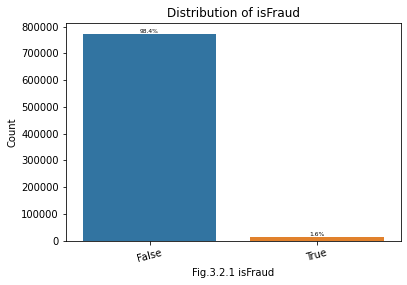

In [19]:
unique_counts = df['isFraud'].value_counts()

sns.barplot(x=unique_counts.index, y=unique_counts.values)
total_counts = len(df['isFraud'])

plt.xticks(rotation=15)
plt.ylabel('Count')
plt.xlabel('Fig.3.2.1 isFraud')
plt.title('Distribution of isFraud')

for j, count in enumerate(unique_counts.values):
    percentage = (count / total_counts) * 100
    plt.text(j, count, f"{percentage:.1f}%", ha='center', va='bottom',fontsize=6)
    
plt.show()

## <font color='blue'>Insight

- ### <font color='blue'> The target variable is imbalance, fraud rate is only 1.6%.

## 3.1.2.2 creditLimit

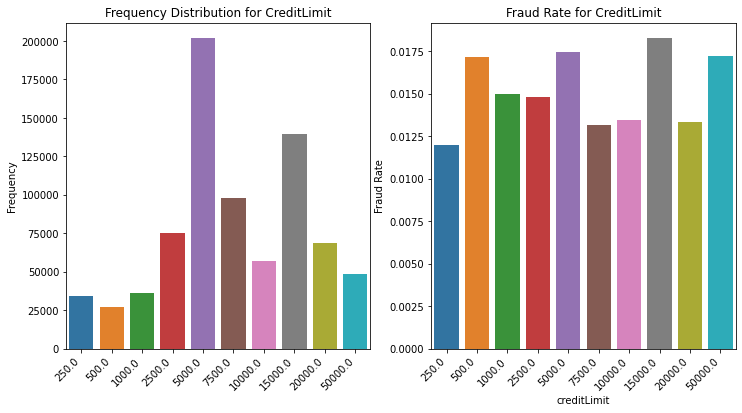

In [20]:
fraud_rate = df.groupby('creditLimit')['isFraud'].mean()
frequency = df['creditLimit'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Frequency Distribution for CreditLimit') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Fraud Rate for CreditLimit') 
ax2.set_ylabel('Fraud Rate') 

plt.show()

## <font color='blue'> Insight of creditLimit: 
### <font color='blue'>1) There are 10 types of creditLimit range from 250 t0 50000, and the top 3 are "5000", "15000","7500"
### <font color='blue'>2) Fraud rate for each categories are similar

## 3.1.2.3 posEntryMode

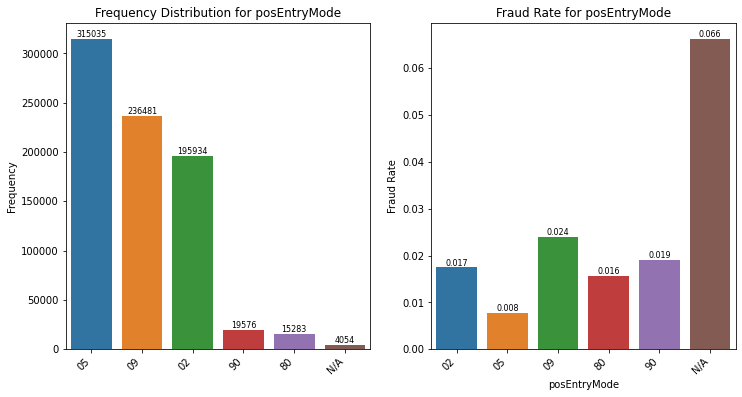

In [21]:
fraud_rate = df.groupby('posEntryMode')['isFraud'].mean()
frequency = df['posEntryMode'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Frequency Distribution for posEntryMode') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Fraud Rate for posEntryMode') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=8)

plt.show()

In [22]:
mapping = {"05": 1, "80": 2, "02":3, "90": 4, "09": 5, "N/A":6}

# Apply the mapping to the posEntryMode column
df["pos_Entry_Mode"] = df["posEntryMode"].map(mapping)

## <font color='blue'>Insight of posEntryMode
### <font color='blue'>For posEntryMode, 05 has the lowest fraud rate, then (02,80,9,09), if posEntryMode is None, it performances the worse

## 3.1.2.4 posConditionCode

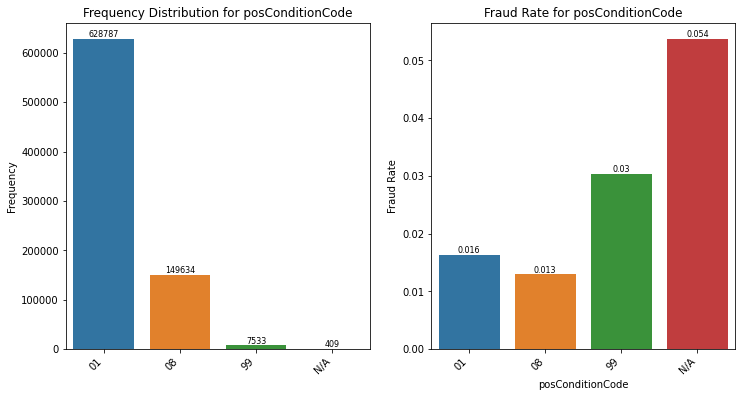

In [23]:
fraud_rate = df.groupby('posConditionCode')['isFraud'].mean()
frequency = df['posConditionCode'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Frequency Distribution for posConditionCode') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Fraud Rate for posConditionCode') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=8)

plt.show()

In [24]:
mapping = {"08": 1, "01": 2, "99": 3, "N/A":4}

# Apply the mapping to the posEntryMode column
df["pos_Condition_Code"] = df["posConditionCode"].map(mapping)

## <font color='blue'>Insight of posConditionCode
### <font color='blue'>1) posConditionCode of 99 is around two times more likely to be fraud then code of 01 and 08
### <font color='blue'>2) If posConditionCode is null, the fraud rate is 3 times more than the overall fraud rate(1.6%)

## 3.1.2.5 merchantCategoryCode

Unique value: ['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care' 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']


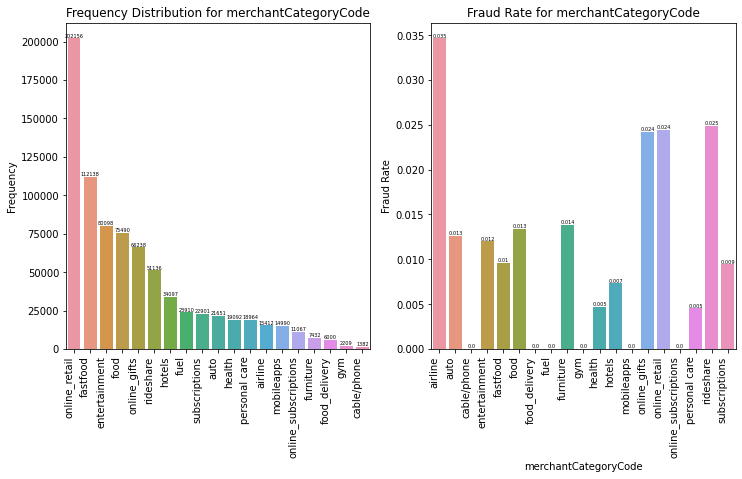

In [25]:
print(f"Unique value: {df['merchantCategoryCode'].unique()}")

fraud_rate = df.groupby('merchantCategoryCode')['isFraud'].mean()
frequency = df['merchantCategoryCode'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_title('Frequency Distribution for merchantCategoryCode') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='right')
ax2.set_title('Fraud Rate for merchantCategoryCode') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(i, value, str(value), ha='center', va='bottom', fontsize=5)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=5)

plt.show()

## <font color='blue'>Insight of merchantCategoryCode
### <font color='blue'>1. Fraud rate ditribution could be divide into 4 groups, from high to low (group1>group2>group3>group4): 
- ### <font color='green'>group1: ['rideshare','online_retail','online_gifts', 'airline']
- ### <font color='green'>group2: ['entertainment', 'fastfood', 'auto', 'food', 'furniture', 'subscriptions']
- ### <font color='green'>group3: ['health', 'personal care', 'hotels'] 
- ### <font color='green'>group4: ['mobileapps', 'food_delivery', 'gym', 'fuel', 'online_subscriptions', 'cable/phone']

## 3.1.2.6 transactionType

Unique value of: ['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL']


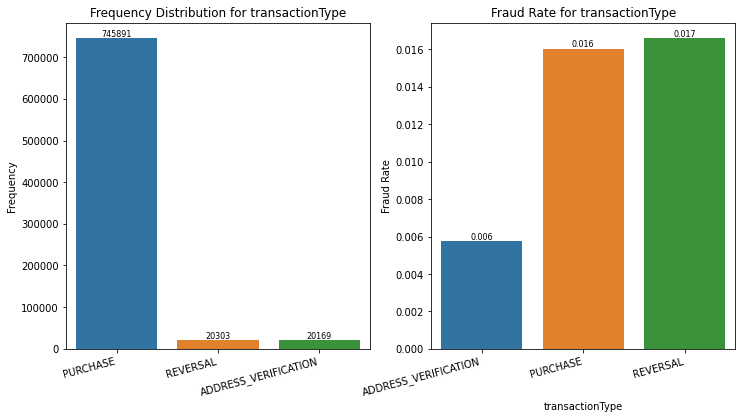

In [26]:
print(f"Unique value of: {df['transactionType'].unique()}")

fraud_rate = df.groupby('transactionType')['isFraud'].mean()
frequency = df['transactionType'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
ax1.set_title('Frequency Distribution for transactionType') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
ax2.set_title('Fraud Rate for transactionType') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=8)

plt.show()

In [27]:

mapping = {"ADDRESS_VERIFICATION": 1, "PURCHASE": 2, "REVERSAL": 2}

# Apply the mapping to the posEntryMode column
df["transaction_type"] = df["transactionType"].map(mapping)

## <font color='blue'>Insight
- ### <font color='blue'>For transaction_type, the fraud rate of ADDRESS_VERIFICATION is around 1/3 of the other two types

## 3.1.2.7 cardPresent

Unique value of: [False  True]


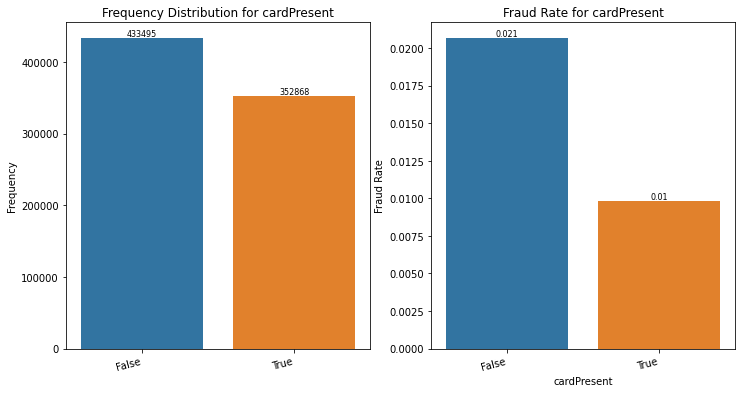

In [28]:
print(f"Unique value of: {df['cardPresent'].unique()}")

fraud_rate = df.groupby('cardPresent')['isFraud'].mean()
frequency = df['cardPresent'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
ax1.set_title('Frequency Distribution for cardPresent') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
ax2.set_title('Fraud Rate for cardPresent') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=8)

plt.show()

In [29]:
mapping = {True: 1, False: 2}

# Apply the mapping to the posEntryMode column
df["card_present"] = df["cardPresent"].map(mapping)

## <font color='blue'>Insight
### <font color='blue'>The frequency distribution of card not present is slightly higher than card present
### <font color='blue'>The fraud rate of card not present is around 2 times more than card present

## 3.1.2.8 Numeric features distribution

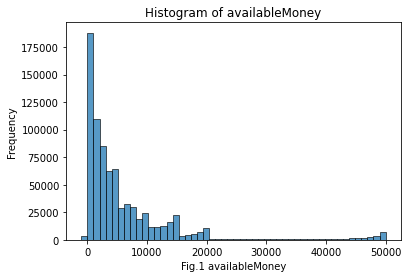

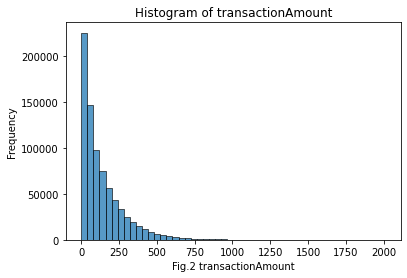

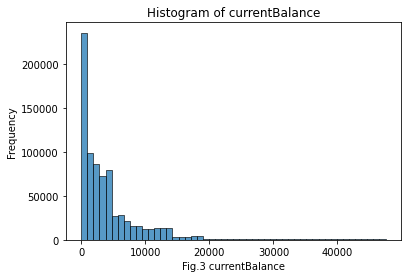

In [30]:
for i, col in enumerate(numeric_columns):

    if col !='creditLimit':
        # df[col].hist(figsize=(12,8), bins=50)

        # sns.histplot(df=df, , bins=50)
        sns.histplot(data=df, x=col, bins=50)

        plt.xlabel(f'Fig.{i} {col}')
        plt.ylabel(f'Frequency')
        plt.title(f'Histogram of {col}')
        plt.show()

## <font color='blue'>Insight
- ### <font color='blue'>The distribution of availableMoney, transactionAmount, and currentBalance is right skewed.

##  3.1.2.9 Data Wrangling - Duplicate Transactions

### 1) Assuming that reversal could happen days later, not necessary to be continue. 
### <font color='blue'> In this case, total_reversed_trans number is 20303, and total reversed transaction amount is 2,821,792.5

In [31]:
# Identify reversed transactions
reversed_trans= df[df['transactionType'] == 'REVERSAL']

# For reversed transactions
total_reversed_trans = reversed_trans.shape[0]
total_reversed_amount = round(reversed_trans['transactionAmount'].sum(),2)

total_reversed_trans, total_reversed_amount


(20303, 2821792.5)

### 2) When calculating the multi swipe, we could define it as below: 
### <font color='blue'> Definition: Within certain period of time, the features' value  are the same except transaction time:
### <font color='green'> ('customerId','acqCountry', 'cardCVV','merchantName', 'cardPresent','transactionAmount','isFraud')
### <font color='blue'> Calculation Steps:
### <font color='green'> Step1: we have to exclude the reversal transaction; 
### <font color='green'> Step2: set a time threshold. By ploting the time vs number of multi swipe, we find the turning point is at 3 min;
### <font color='green'> Step3: Calculate the multi swipe number and amount.


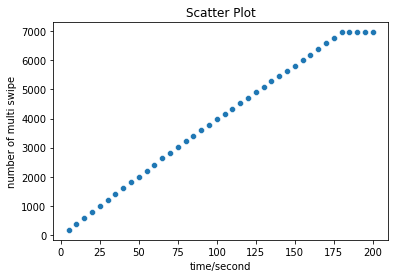

In [32]:
# Sorting by 'transactionDateTime'
df = df.sort_values('transactionDateTime')

t=0
x=[]
y=[]
z=[]

for i in range(40):
    t+=5
    df1 = df[df['transactionType'] != 'REVERSAL']
    # Sorting by 'transactionDateTime'
    df1 = df1.sort_values('transactionDateTime')

    # Identify multi-swipe transactions
    df1['is_duplicated'] = df1.duplicated(['customerId','acqCountry', 'cardCVV','merchantName', 'cardPresent','transactionAmount','isFraud'], keep=False)
    df1['time_diff'] = df1.groupby(['customerId','acqCountry', 'cardCVV','merchantName', 'cardPresent','transactionAmount','isFraud'])['transactionDateTime'].diff()
    df1['is_multi_swipe'] = (df1['is_duplicated'] & (df1['time_diff'] < pd.Timedelta(seconds=t)))

    multi_swipe_trans = df1[df1['is_multi_swipe']]

    # For multi-swipe transactions
    # Note: exclude the first "normal" transaction
    multi_swipe_trans = multi_swipe_trans.sort_values('transactionDateTime').drop_duplicates(['customerId','acqCountry', 'cardCVV','merchantName', 'cardPresent','transactionAmount','isFraud'], keep='last')
    total_multi_swipe_trans = multi_swipe_trans.shape[0]
    total_multi_swipe_amount = multi_swipe_trans['transactionAmount'].sum()

    # print(f'When time threshold is {t} second: \n    The total number of multi swipe is {total_multi_swipe_trans} \n    Total multi swipe amount is {total_multi_swipe_amount}')
    # print('\n')

    x.append(t)
    y.append(total_multi_swipe_trans)
    z.append(total_multi_swipe_amount)

sns.scatterplot(x=x, y=y)

# Set the labels and title
plt.xlabel('time/second')
plt.ylabel('number of multi swipe')
plt.title('Scatter Plot')

# Display the plot
plt.show()


In [33]:
print(f'When time threshold is 180 second: \n--The total number of multi swipe is {total_multi_swipe_trans} \n--Total multi swipe amount is {total_multi_swipe_amount}')


When time threshold is 180 second: 
--The total number of multi swipe is 6966 
--Total multi swipe amount is 1000527.6299999999


# 3.2 Feature Engineering- Merchant Dimension

### 3.2.1 Merchant Name
- ### <font color='green'> Create new feature call merchant_trans_outlier, to check if the transaction is "too small", "normal" or "too big" for a centain merchant; Mapping to code "1", "2", "3" respectly

In [34]:
len(df['merchant_name'].unique())

205

In [35]:

merchant_transaction_summary = []

for merchant in df['merchant_name'].unique():
    sub_df = df[df['merchant_name']==merchant]
    trans = sub_df['transactionAmount'].describe().to_dict()
    merchant_transaction_summary.append([merchant, trans])

merchant_transaction_summary = pd.DataFrame(merchant_transaction_summary, columns=['merchant_name', 'merchant_trans_summary'])

df = pd.merge(df, merchant_transaction_summary, on='merchant_name', how='left')

In [36]:
merchant_transaction_summary

,merchant_name,merchant_trans_summary
0,Washington Post,"{'count': 1369.0, 'mean': 150.96576333089848, ..."
1,staples.com,"{'count': 16980.0, 'mean': 145.45076501766786,..."
2,cheapfast.com,"{'count': 16858.0, 'mean': 144.49088681931423,..."
3,discount.com,"{'count': 16731.0, 'mean': 145.6352172613711, ..."
4,Fast Repair,"{'count': 1109.0, 'mean': 143.41151487826872, ..."
...,...,...
200,Verizon Wireless,"{'count': 45.0, 'mean': 103.50333333333334, 's..."
201,Duane Reed,"{'count': 28.0, 'mean': 145.32892857142858, 's..."
202,Sprint Communications,"{'count': 196.0, 'mean': 104.19801020408163, '..."
203,Barbells,"{'count': 117.0, 'mean': 31.670256410256407, '..."


In [37]:
def classify_merchant_trans(transactionAmount, merchant_trans_summary):
    p_75 = merchant_trans_summary['75%']
    p_25 = merchant_trans_summary['25%']
    IQR= (p_75-p_25)*1.5
    if transactionAmount > p_75+IQR:
        return 3 # transaction amount too big
    elif transactionAmount< p_25 - IQR:
        return 1 # transaction amount too samll
    else:
        return 2 # transaction amount normal

df['merchant_trans_outlier'] = df.apply(lambda x: classify_merchant_trans(x.transactionAmount, x.merchant_trans_summary), axis=1)



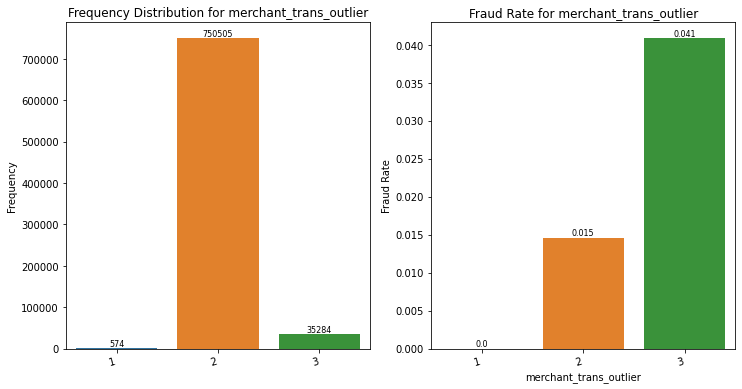

In [38]:
fraud_rate = df.groupby('merchant_trans_outlier')['isFraud'].mean()
frequency = df['merchant_trans_outlier'].value_counts()

# Create a figure and a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the first bar plot on ax1
sns.barplot(data=df, x=frequency.index, y=frequency.values, ax=ax1,  edgecolor=None)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
ax1.set_title('Frequency Distribution for merchant_trans_outlier') 
ax1.set_ylabel('Frequency') 

# Create the first bar plot on ax1
sns.barplot(data=df, x=fraud_rate.index, y=fraud_rate.values, ax=ax2, edgecolor=None)
ax2.tick_params(axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
ax2.set_title('Fraud Rate for merchant_trans_outlier') 
ax2.set_ylabel('Fraud Rate') 

# Add figure labels for each subcategory to ax1
for i, value in enumerate(frequency.values):
    ax1.text(frequency.index[i]-1, value, str(value), ha='center', va='bottom', fontsize=8)

# Add figure labels for each subcategory to ax2
for i, value in enumerate(fraud_rate.values):
    ax2.text(i, value, str(round(value,3)), ha='center', va='bottom', fontsize=8)

plt.show()

## <font color='blue'>Insight
- ### <font color='blue'>if transaction amount for a certain merchant is too small, the fraud rate is 0. If too big, it is around 3 times more likely to be fraud.

## 3.2.2 merchatCategoryCode

### Assumption: For different merchant category, the fraud rate is different

In [39]:
merchant_category_safety = pd.pivot_table(data=df, index ='merchantCategoryCode',
                                          columns='isFraud',
                                          values = 'customerId',
                                          fill_value=0,
                                          aggfunc='count')
merchant_category_safety['merchant_code_fraud_ratio'] = merchant_category_safety[True] / (merchant_category_safety[True]+merchant_category_safety[False])

merchant_category_safety.reset_index(inplace=True)
merchant_category_safety.sort_values(by='merchant_code_fraud_ratio', ascending=False)

isFraud,merchantCategoryCode,False,True,merchant_code_fraud_ratio
0,airline,14878,534,0.034648
17,rideshare,49864,1272,0.024875
14,online_retail,197218,4938,0.024427
13,online_gifts,64632,1606,0.024246
8,furniture,7329,103,0.013859
5,food,74476,1014,0.013432
1,auto,21378,273,0.012609
3,entertainment,79137,961,0.011998
4,fastfood,111064,1074,0.009577
18,subscriptions,22685,216,0.009432


In [40]:
df = pd.merge(df, merchant_category_safety[['merchantCategoryCode', 'merchant_code_fraud_ratio']], on='merchantCategoryCode')

## 3.2.3 Merchant_name fraud ratio

In [41]:
merchant_name_fraud = pd.pivot_table(data=df, index='merchant_name', columns='isFraud',
                                     values='customerId', aggfunc='count', fill_value=0).reset_index()
merchant_name_fraud['merchant_name_fraud_ratio'] = merchant_name_fraud[True]/ (merchant_name_fraud[True]+ merchant_name_fraud[False])

merchant_name_fraud.sort_values(by='merchant_name_fraud_ratio', ascending=False)

isFraud,merchant_name,False,True,merchant_name_fraud_ratio
16,American Airlines,2844,295,0.093979
77,Fresh Flowers,7781,553,0.066355
192,ethanallen.com,466,24,0.048980
40,Convenient Auto Services,1013,45,0.042533
131,Rove Concepts,452,20,0.042373
...,...,...,...,...
129,Rock Weights,671,0,0.000000
45,DailyOmnivore,1787,0,0.000000
22,Barbells,117,0,0.000000
153,TMobile Wireless,66,0,0.000000


In [42]:
df = pd.merge(df, merchant_name_fraud[['merchant_name', 'merchant_name_fraud_ratio']], on ='merchant_name', how='left')

## <font color='blue'>Insight
- ### <font color='blue'>Top five fraud rate of merchant names are: 
  ###   <font color='green'>American Airlines, Fresh Flowers, ethanallen.com, Convenient Auto Services, Rove Concepts

## 3.3 Cusotmer Behavior

## 3.3.1 transaction gap

- ### Assumption: for each customer's each card, if transaction gap is too small, it's more likely to be fraud

In [43]:
# Day gap between current datetime and last transaction datatime by customer

df.sort_values(by=['customerId', 'transactionDateTime'], inplace=True)
df['cus_trans_gap_by_second'] = df.groupby(['customerId'])['transactionDateTime'].diff()

# Day gap between current datetime and last transaction datatime by customer, by card

df.sort_values(by=['customerId', 'cardLast4Digits','transactionDateTime'], inplace=True)
df['cus_card_trans_gap_by_second'] = df.groupby(['customerId','cardLast4Digits'])['transactionDateTime'].diff()



In [44]:
def get_second(gap):
    try:
        res = gap.seconds
    except:
        res=-1
    return res 

df['cus_trans_gap_by_second'] = df['cus_trans_gap_by_second'].apply(get_second)
df['cus_card_trans_gap_by_second'] = df['cus_card_trans_gap_by_second'].apply(get_second)

In [45]:
trans_freq_by_cus = df.groupby('customerId')['cus_trans_gap_by_second'].mean()
trans_freq_by_cus = pd.DataFrame({'customerId': trans_freq_by_cus.index, 'mean_cus_trans_gap': trans_freq_by_cus.values})

df = pd.merge(df, trans_freq_by_cus[['customerId', 'mean_cus_trans_gap']], on ='customerId', how='left')

In [46]:
trans_freq_by_cus_by_car = df.groupby('customerId')['cus_card_trans_gap_by_second'].mean()
trans_freq_by_cus_by_car = pd.DataFrame({'customerId': trans_freq_by_cus_by_car.index, 'mean_cus_card_trans_gap': trans_freq_by_cus_by_car.values})

df = pd.merge(df, trans_freq_by_cus_by_car[['customerId', 'mean_cus_card_trans_gap']], on ='customerId', how='left')

df['trans_gap_ratio_cus'] = df['cus_card_trans_gap_by_second'] / df['mean_cus_card_trans_gap']
df['trans_gap_ratio_card'] = df['cus_trans_gap_by_second'] / df['mean_cus_card_trans_gap']

In [47]:
df['trans_gap_ratio_cus'] = df['cus_card_trans_gap_by_second'] / df['mean_cus_card_trans_gap']
df['trans_gap_ratio_card'] = df['cus_trans_gap_by_second'] / df['mean_cus_card_trans_gap']

## 3.3.2 Credit ratio
- ### Assumption: If the transaction ratio is close to 1, it's more likely to be fraud

In [48]:
df['credit_used_ratio'] = df['transactionAmount'] / df['creditLimit']
df['credit_left_ratio'] = df['availableMoney']/ df['creditLimit']
df['balance_ratio'] = df['currentBalance'] / df['creditLimit']

## 3.3.3 Transaction ratio
- ### Assumption: For each customer, if the transaction is much higher than their normal transaction amount, it's more likely to be fraud

In [49]:
# customer transaction amount take up % of each category transaction amount

customer_category_summary = pd.pivot_table(data = df[df['isFraud']==False],
                                           index = ['customerId', 'merchantCategoryCode'],
                                           values = 'transactionAmount',
                                           aggfunc=np.mean
                                           ).reset_index()

customer_category_summary.rename(columns= {"transactionAmount": "cus_transaction_avg_amount_by_category"}, inplace=True)

df = pd.merge(df, customer_category_summary, on=['customerId', 'merchantCategoryCode'], how='left')
df['cus_trans_ratio_by_cat'] = df['transactionAmount'] / df['cus_transaction_avg_amount_by_category']

In [50]:
customer_merchant_summary = pd.pivot_table(data = df[df['isFraud']==False],
                                           index = ['customerId', 'merchant_name'],
                                           values = 'transactionAmount',
                                           aggfunc=np.mean
                                           ).reset_index()

customer_merchant_summary.rename(columns= {"transactionAmount": "cus_transaction_avg_amount_by_merchant"}, inplace=True)

df = pd.merge(df, customer_merchant_summary, on=['customerId', 'merchant_name'], how='left')
df['cus_trans_ratio_by_merchant'] = df['transactionAmount'] / df['cus_transaction_avg_amount_by_merchant']

## 3.3.4 Boolean feature

- ### Check if the enteredCVV is the same as the cardCVV

In [51]:
#Combine columns cardCVV and enteredCVV as is_correct_CVV

df['is_correct_CVV'] = df['cardCVV']==df['enteredCVV']

df['is_acq_merchant_country_equal'] = df['acqCountry'] ==df['merchantCountryCode']


## 3.3.5 Transaction period
- Assumption: transaction happend in different time period could be a sign of fraud

In [52]:
# # Extract features from 'transactionDataTime'
df['transaction_hour'] = df['transactionDateTime'].dt.hour
df['transaction_day_of_week'] = df['transactionDateTime'].dt.dayofweek
df['account_months'] = df['transactionDateTime'].dt.month - df['accountOpenDate'].dt.month

# 5. Model Training

### 5.1 Data Preparation

In [53]:

features = [
       'is_acq_merchant_country_equal', 'pos_Entry_Mode', 'pos_Condition_Code',
       'transaction_type', 'card_present', 
       'merchant_trans_outlier', 'merchant_code_fraud_ratio',
       'merchant_name_fraud_ratio', 
       'mean_cus_card_trans_gap', 'credit_used_ratio', 'credit_left_ratio',
       'balance_ratio',
       'cus_trans_ratio_by_cat', 
       'cus_trans_ratio_by_merchant', 'is_correct_CVV', 'transaction_hour',
       'transaction_day_of_week', 'account_months','trans_gap_ratio_cus','trans_gap_ratio_card']

id = ['accountNumber','customerId']
target = 'isFraud'

In [54]:
df_cleaned = df[features+id+[target]]

In [55]:
df_cleaned.fillna(-99, inplace=True)
df_cleaned.replace(np.inf, 999, inplace=True)

In [56]:
# Upsampling train set
data_train, data_test = train_test_split(df_cleaned, test_size=0.25, random_state=75050)

# Setting up testing and training sets
X_train, X_test, y_train, y_test = data_train[features], data_test[features], data_train[target], data_test[target]

### 5.2 Model Selecting

In [57]:
# Define models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),  # To suppress a warning related to a deprecated feature in XGBoost
    ('LightGBM', LGBMClassifier())
]

# Model pipeline
f1_scores = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_scores[name] = f1_score(y_test, y_pred)

# Print each model's F1 score
f1_scores_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])
print(f1_scores_df)

# Find the best model based on the F1 score
best_model = max(f1_scores, key=f1_scores.get)
print("Best model is:", best_model)


                 Model  F1 Score
0  Logistic Regression  0.434499
1        Decision Tree  0.366967
2        Random Forest  0.502034
3    Gradient Boosting  0.508314
4              XGBoost  0.509581
5             LightGBM  0.499305
Best model is: XGBoost


### 5.3 Fine-tuning

### Upsample

In [58]:
# Upsampling train set
data_train, data_test = train_test_split(df_cleaned, test_size=0.25, random_state=75050)

c=4
max_f1 = 0

for i in range(c):

    print(data_train[target].value_counts())
    fraud_rate =round(data_train[target].value_counts()[1]/len(data_train)*100,1)

    # Setting up testing and training sets
    X_train, X_test, y_train, y_test = data_train[features], data_test[features], data_train[target], data_test[target]

    bst = XGBClassifier(n_estimators = 500, max_depth=5, learning_rate=0.05, objective='binary:logistic')

    bst.fit(X_train, y_train)
    y_train_preds = bst.predict(X_train)
    preds = bst.predict(X_test)

    print(f"Report for train dataset when fraud rate is {fraud_rate}%:")
    print(classification_report(y_train, y_train_preds))
    print(f"Report for test dataset when fraud rate is {fraud_rate}%:")
    print(classification_report(y_test, preds))
    f1 = f1_score(y_test, preds)
    
    if f1>max_f1:
        best_model = bst
        joblib.dump(bst, filename='/Users/shouzhenghuang/fraud_dection/xgb_model.joblib')
        
    data_fraud = data_train[data_train[target]==True]
    data_train = pd.concat([data_train,data_fraud])

isFraud
False    580474
True       9298
Name: count, dtype: int64
Report for train dataset when fraud rate is 1.6%:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    580474
        True       0.99      0.35      0.52      9298

    accuracy                           0.99    589772
   macro avg       0.99      0.68      0.76    589772
weighted avg       0.99      0.99      0.99    589772

Report for test dataset when fraud rate is 1.6%:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    193472
        True       0.99      0.34      0.51      3119

    accuracy                           0.99    196591
   macro avg       0.99      0.67      0.75    196591
weighted avg       0.99      0.99      0.99    196591

isFraud
False    580474
True      18596
Name: count, dtype: int64
Report for train dataset when fraud rate is 3.1%:
              precision    recall  f1-score   support

       Fal

## <font color='blue'>Insight
### <font color='blue'>1) We can use value of precision and recall as a guide to adjust the percentage of upsampling to achieve the best model performance  <font color='green'>
- ####  <font color='green'>    Precision = TP/(TP+FP); the higher the Precision, means the lower the FP(type I error), in this case, low FP means if the transaction is not Fraud, it's less likely to predict as Fraud; And this is because the amount of not Fraud is high.
- ####   <font color='green'>   Recall = TP/(TP+FN); the lower the Recall, the higher FN(type II error), in this case, high FN means the model tend to predict the Fraud as none Fraud; And that's becuase the percentage of Fraud data is less; And increase the amount of Fraud data could increase the Recall value;

### <font color='blue'>2) As checked, grid search does not contribute to the improvement of F1 score. The main reason is that there is no F1 score evaluation metric in xgboost

### 5.4 Feature Importance

In [59]:
# Feature Importance
features_importance_report = pd.DataFrame({'Feature': X_train.columns, "Importance": best_model.feature_importances_})
features_importance_report.sort_values(by='Importance', ascending=False)

,Feature,Importance
13,cus_trans_ratio_by_merchant,0.255959
1,pos_Entry_Mode,0.167733
6,merchant_code_fraud_ratio,0.128267
7,merchant_name_fraud_ratio,0.075344
4,card_present,0.058768
12,cus_trans_ratio_by_cat,0.046452
9,credit_used_ratio,0.045317
2,pos_Condition_Code,0.040586
14,is_correct_CVV,0.027499
8,mean_cus_card_trans_gap,0.026143


## 5.5 PDP Analysis (Partial Dependence Plot)

In [60]:
pdp_data = df_cleaned[features+[target]]
pdp_target = target

### 5.5.1 customer_transaction_ratio_by_merchant_name

- ### The meaning of the feature: For a certain merchant_name, each customers have their own prefer and pattern. And this feature will capture the transaction amount account for the average spending for certain merchant_name;
- ### "-99" is the code indicate it's the first time the customer purchase the merchant; 

In [61]:
# cus_trans_ratio_by_merchant
target_cus_trans_ratio_by_merchant = info_plots.TargetPlot(
    df=pdp_data,
    feature="cus_trans_ratio_by_merchant",
    feature_name="customer_transaction_ratio_by_merchant_name",
    target=pdp_target,
    num_grid_points=10,
    grid_type='percentile',
    percentile_range=None,
    grid_range=None,
    cust_grid_points=None,
    show_outliers=False,
    endpoint=True,
)

fig, axes, summary_df = target_cus_trans_ratio_by_merchant.plot(
    show_percentile=True,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine='plotly',
    template='plotly_white',
)
fig

In [1]:
# In case the PDP plot not showing up, I paste it below

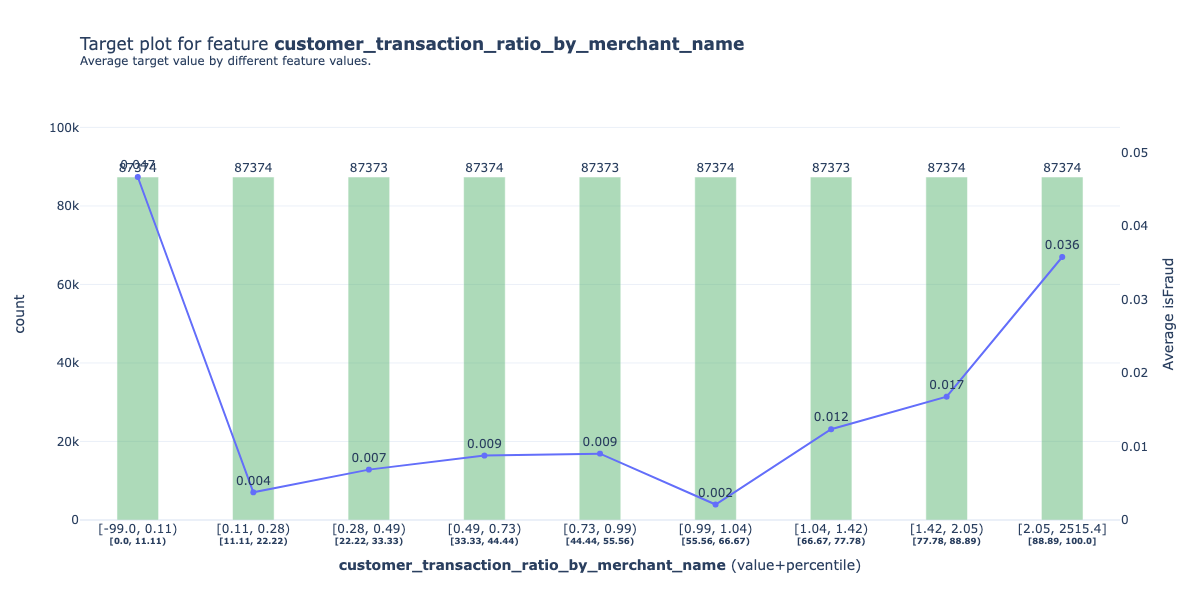

In [62]:
summary_df

,x,value,percentile,count,isFraud
0,0,"[-99.0, 0.11)","[0.0, 11.11)",87374,0.046673
1,1,"[0.11, 0.28)","[11.11, 22.22)",87374,0.003765
2,2,"[0.28, 0.49)","[22.22, 33.33)",87373,0.006856
3,3,"[0.49, 0.73)","[33.33, 44.44)",87374,0.008767
4,4,"[0.73, 0.99)","[44.44, 55.56)",87373,0.009030
5,5,"[0.99, 1.04)","[55.56, 66.67)",87374,0.002106
6,6,"[1.04, 1.42)","[66.67, 77.78)",87373,0.012349
7,7,"[1.42, 2.05)","[77.78, 88.89)",87374,0.016778
8,8,"[2.05, 2515.4]","[88.89, 100.0]",87374,0.035789


## <font color='blue'>Insight
- ### From above result, it shows if it's the first time customer purchase the goods, it's more likely to be fraud.
- ### If the transaction amount is 2 times more than the customer itself average spending on this merchant, there's 3.6% fraud rate, which is 2+ times more than overall fraud rate;
- ### Once the ratio exceed 1, the fraud rate increase with the increase of transaction ratio 

## 5.5.2 Credit_used_ratio

In [63]:
# # mapping = {"05": 1, "80": 2, "02":3, "90": 4, "09": 5, "N/A":6}

# pdp_data['pos_Entry_Mode'].unique()


array([1, 5, 3, 6, 4, 2])

In [64]:
target_credit_used_ratio = info_plots.TargetPlot(
    df=pdp_data,
    feature="credit_used_ratio",
    feature_name="credit_used_ratio",
    target=pdp_target,
    num_grid_points=20,
    grid_type='percentile',
    percentile_range=None,
    grid_range=None,
    cust_grid_points=None,
    show_outliers=False,
    endpoint=True,
)

fig, axes, summary_df = target_credit_used_ratio.plot(
    show_percentile=True,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine='plotly',
    template='plotly_white',
)

fig

In [ ]:
# In case the PDP plot not showing up, I paste it below

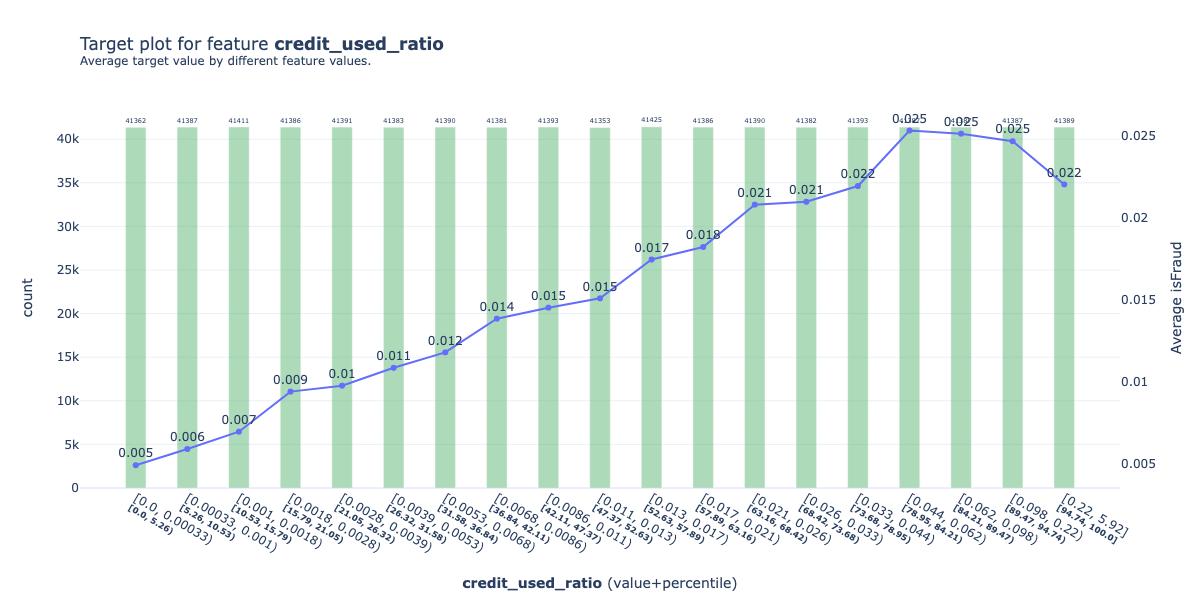

In [65]:
summary_df

,x,value,percentile,count,isFraud
0,0,"[0.0, 0.00033)","[0.0, 5.26)",41362,0.004932
1,1,"[0.00033, 0.001)","[5.26, 10.53)",41387,0.005920
2,2,"[0.001, 0.0018)","[10.53, 15.79)",41411,0.006979
3,3,"[0.0018, 0.0028)","[15.79, 21.05)",41386,0.009423
4,4,"[0.0028, 0.0039)","[21.05, 26.32)",41391,0.009785
5,5,"[0.0039, 0.0053)","[26.32, 31.58)",41383,0.010874
6,6,"[0.0053, 0.0068)","[31.58, 36.84)",41390,0.011814
7,7,"[0.0068, 0.0086)","[36.84, 42.11)",41381,0.013871
8,8,"[0.0086, 0.011)","[42.11, 47.37)",41393,0.014544
9,9,"[0.011, 0.013)","[47.37, 52.63)",41353,0.015114


## <font color='blue'>Insight
- ###  <font color='blue'>With the increased credit_used_ratio, the fraud rate increased, once it pass the range of [4.4% ~ 6.2%], the fraud rate starting descrease 
- ###  <font color='blue'>It could be the reason that the 5% threshold is the threshold which effect the customer's FICO score, so once it exceed the threshold, the customer become prudent and the fraud rate decrease 

# 6. Business Suggestion

- ### <font color='blue'>After the model has been trained, it's always good to go deep into the result and find meaningful business insight so as to reduce the Fraud rate.

- ### <font color='blue'>In this case, I tend to check the statistic distribution of the final probability of both True and False. And analysis the statistic describe of all True Positive, True Negtive, False Positive, False Negtive. And find guidance based on that to take business action so as to improve the efficiency and reduce the Fraud rate at the same time

In [67]:
#  distribution of the probability
test_pred_prob =best_model.predict_proba(X_test.values)
data_test['pred_prob'] =np.amax(test_pred_prob,axis=1)
data_test['pred_y'] =best_model.predict(X_test.values)

a =data_test['pred_prob'].describe().reset_index()

# TruePositive
b =data_test[(data_test['pred_y']==1) & (data_test['isFraud']==True) ]['pred_prob'].describe().reset_index()
b.rename(columns ={'pred_prob':'TruePositive pred_prob'},inplace=True)

# FalseNegative
c =data_test[(data_test['pred_y']==0) & (data_test['isFraud']==False) ]['pred_prob'].describe().reset_index()
c.rename(columns ={'pred_prob':'TrueNegative pred_prob'},inplace=True)

#  type I error
d =data_test[(data_test['pred_y']==1) & (data_test['isFraud']==False) ]['pred_prob'].describe().reset_index()
d.rename(columns ={'pred_prob':'FalsePositive(type I error) pred_prob'},inplace=True)

#  type II error
e= data_test[(data_test['pred_y']==0) & (data_test['isFraud']==True) ]['pred_prob'].describe().reset_index()
e.rename(columns ={'pred_prob':'FalseNegative(type II error) pred_prob'},inplace=True)

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['index'],
                                            how='inner'), [a,b,c,d,e])

df_merged


,index,pred_prob,TruePositive pred_prob,TrueNegative pred_prob,FalsePositive(type I error) pred_prob,FalseNegative(type II error) pred_prob
0,count,196591.000000,1326.000000,192535.000000,937.000000,1793.000000
1,mean,0.940413,0.928017,0.943381,0.603027,0.807205
2,std,0.085117,0.144251,0.079618,0.090116,0.125536
3,min,0.500036,0.500842,0.500051,0.500036,0.501574
4,25%,0.926627,0.990343,0.929761,0.532549,0.720906
5,50%,0.975899,0.999115,0.976461,0.577392,0.826239
6,75%,0.993510,0.999702,0.993513,0.649523,0.910693
7,max,0.999989,0.999989,0.999986,0.949673,0.997530


In [68]:
negeative_thres =0.90
positve_thres =0.95

negative_condition = (data_test['pred_prob']> negeative_thres) &(data_test['pred_y']==0)
positive_condition = (data_test['pred_prob']> positve_thres) &(data_test['pred_y']==1)

partial_data = pd.concat([ data_test[negative_condition],data_test[positive_condition]])

high_prob =pd.pivot_table(data= partial_data,
               index ='pred_y',
               columns='isFraud',
               values='customerId',
               aggfunc='count',
               fill_value=0
               )

high_prob['precision'] =[high_prob.iloc[0][0]/(high_prob.iloc[0][0]+high_prob.iloc[0][1]),
                         high_prob.iloc[1][1]/(high_prob.iloc[1][0]+high_prob.iloc[1][1])
                         ]

display(high_prob)

display(len(partial_data)/len(data_test))

isFraud,False,True,precision
pred_y,,,
0,156438,502,0.996801
1,0,1027,1.000000


0.8035311891185253

# <font color='blue'>Business Suggestions to reduce fraud rate

## <font color='blue'>1. If the model says the transaction is >95% Fraud, then we could just ban it;
## <font color='blue'>2. If the model says the transaction is Fraud, but less then 95%, then we could pending the transaction or send alert notification to customer;
## <font color='blue'>3. If the model says the transaction is >90% non-Fraud, we do nothing on these transaction;
## <font color='blue'>4. If the model says the tansaction is non-Fraud, but <90%, then we could set transaction threshold or other innormal behavior to decision wether to inform customer or not;

# 7. Future Work

###  <font color='blue'>1. More features: customer demographic information, like age, education, zipcode;
###  <font color='blue'>2. Model side:
- ###     Data Spliting: in time (Jan.~ Oct.) model training; out of time (Nov.~ Dec.) validation; 
- ###     Modeling stacking;

### <font color='blue'>3. More PDP Analysis, to get more business insight 